In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData
from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.venn_diagram import venn3_diagram
from visualizations.stacked_area import activity_plot

In [2]:
OP_RED = "#FF0420"
plt.rcParams["font.family"] = "Arial"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 144

In [3]:
DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_04_RPGF3_cleaned_applicant_data.json"

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
slugs_param = "'" + "','".join(slugs) + "'"

Loaded 308 OSS projects from data/RPGF3/2023-11_04_RPGF3_cleaned_applicant_data.json.
Identified 308 unique slugs.


# Presence in past RPGFs

In [4]:
results = execute_query("""
    SELECT c.slug, p.slug, p.name
    FROM collection c
    JOIN collection_projects_project cpp ON c."id" = cpp."collectionId"
    JOIN project p on cpp."projectId" = p."id"
    WHERE c.slug IN ('op-rpgf1', 'op-rpgf2')
    ORDER BY c.slug, p.slug;
""", col_names=False)

cp_mapping = defaultdict(list)
for (collection, project, name) in results:
    cp_mapping[collection].append(project)
cp_mapping['op-rpgf3'] = slugs    

- op-rpgf1: 50 OSS projects
- op-rpgf2: 135 OSS projects
- op-rpgf3: 308 OSS projects


(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

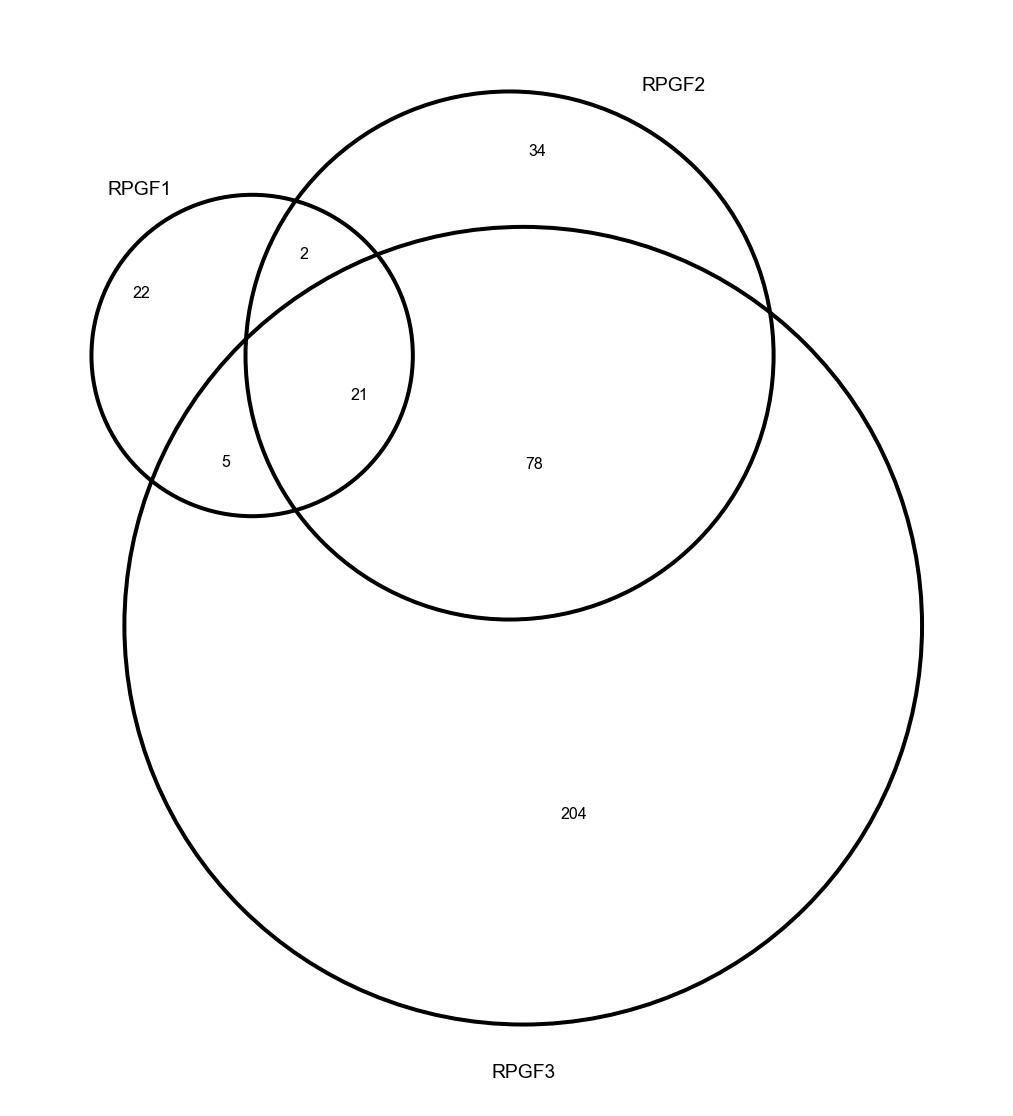

In [5]:
project_sets = []
round_names = []
for collection, project_list in cp_mapping.items():
    project_sets.append(set(project_list))
    round_names.append(collection.replace("op-","").upper())
    print(f"- {collection}: {len(project_list)} OSS projects")
venn3_diagram(project_sets, round_names)

# Coverage snapshot of RPGF3 projects

In [6]:
def horizontal_bar(series, title=""):    
    fig, ax = plt.subplots(figsize=(10,5), dpi=144)
    sns.barplot(series, orient='h', color=OP_RED, ax=ax)
    ax.bar_label(ax.containers[0], padding=2)
    ax.margins(x=.1)
    ax.set_xticks([])
    sns.despine()
    ax.spines[['bottom']].set_visible(False)
    if title:
        ax.set_title(title, fontweight='bold', fontsize=14, loc='left')

In [7]:
results = execute_query(f"""
    SELECT a.type, COUNT(DISTINCT a.id), COUNT(DISTINCT p.slug)
    FROM project p
    JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
    JOIN artifact a ON paa."artifactId" = a."id"
    WHERE p.slug IN ({slugs_param}) AND a.namespace <> 'ETHEREUM'
    GROUP BY a.type;
""", col_names=False)

types, artifact_counts, project_counts = zip(*results)

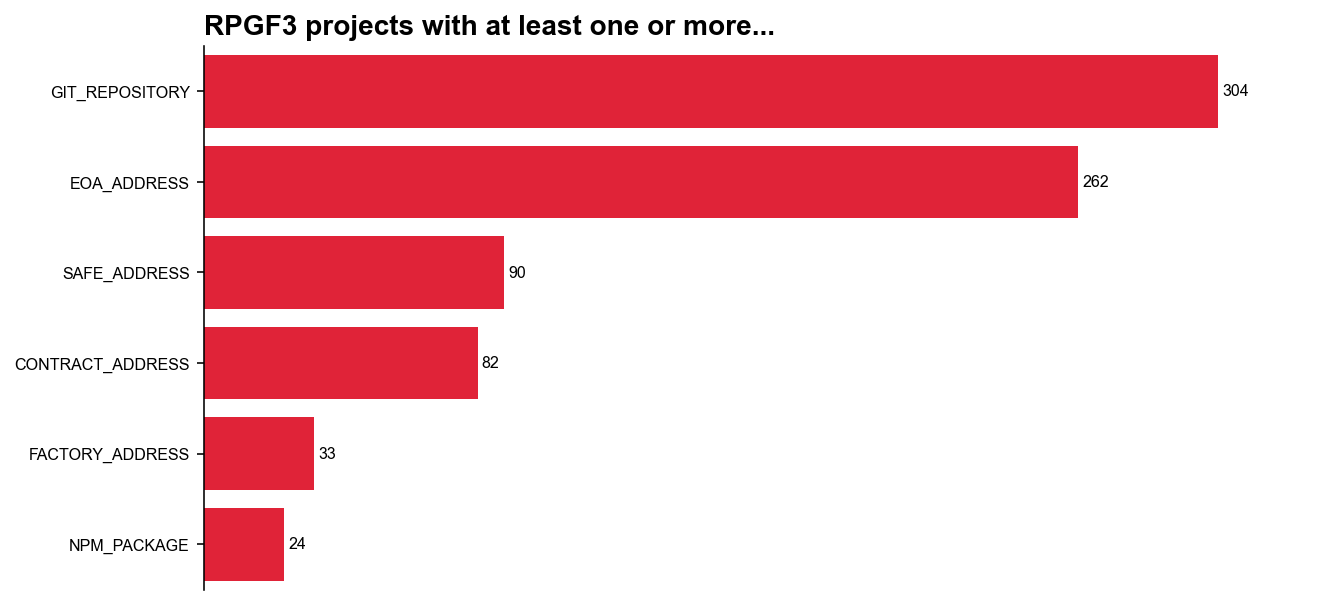

In [8]:
projects_coverage = pd.Series(project_counts, types).sort_values(ascending=False)
horizontal_bar(projects_coverage, "RPGF3 projects with at least one or more...")

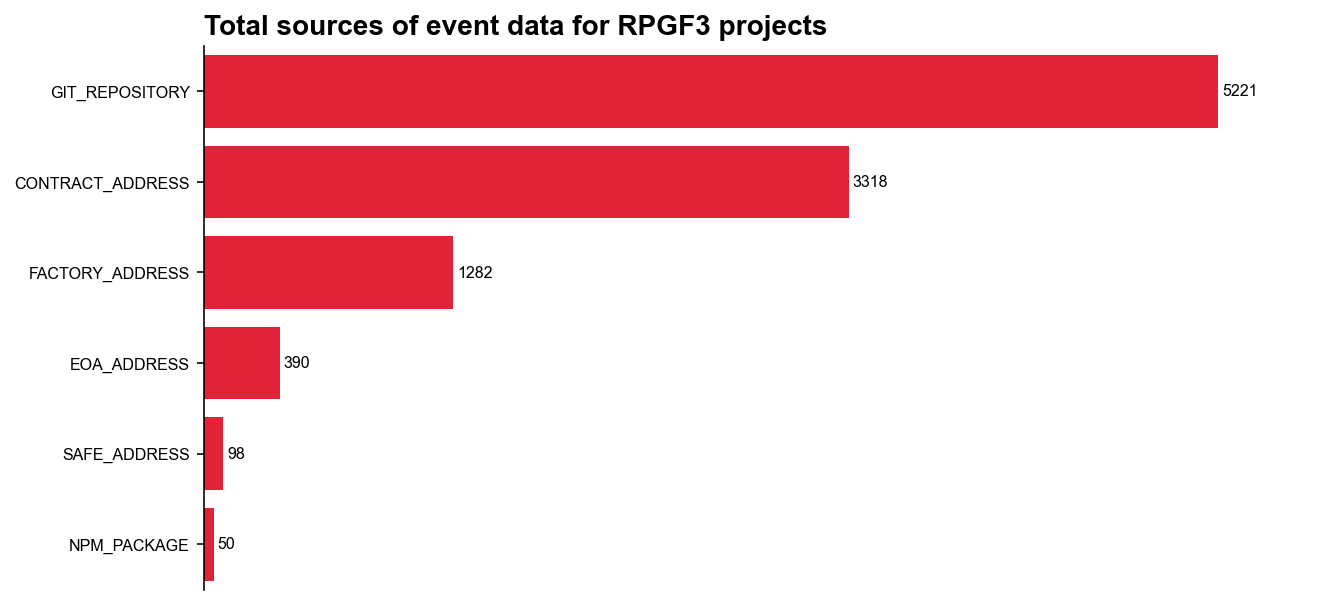

In [9]:
artifacts_coverage = pd.Series(artifact_counts, types).sort_values(ascending=False)
horizontal_bar(artifacts_coverage, "Total sources of event data for RPGF3 projects")

# Activity snapshot of RPGF3 projects

In [10]:
# run query (may take a few minutes)

results = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ({slugs_param})
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_developer")
    FROM Devs
    GROUP BY slug, month;
""", col_names=True)

df_devs = pd.DataFrame(results[1:], columns=results[0])
df_devs.head()

slug    month  sum
0        zora  2017-01    0
1       rotki  2020-08    3
2  coordinape  2022-02    3
3       umbra  2021-08    1
4   limechain  2023-10    3

In [11]:
contribution_heatmap(
    df_devs[df_devs['month'] > '2014-01'], 
    index_col='slug', 
    column_col='month', 
    value_col='sum', 
    sort_label_method='mean',
    cmap='Reds',
    vmax=10
)

(<Figure size 7080x18180 with 1 Axes>, <AxesSubplot:>)

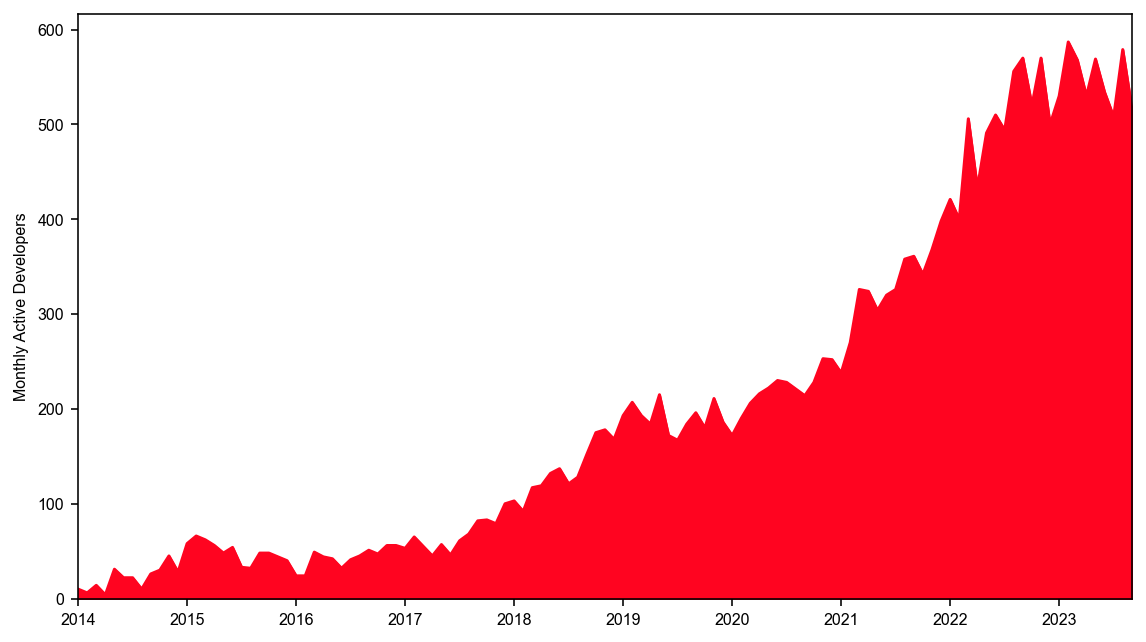

In [12]:
fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
df_devs[(df_devs['month']>='2014-01') & (df_devs['month']<'2023-11')].groupby('month')['sum'].sum().plot(kind='area', ax=ax, color="#FF0420")
ax.set_xlim([0,116])
ax.set_xticks([0,12,24,36,48,60,72,84,96,108])
ax.set_xticklabels(['2014', '2015', '2016', '2017','2018', '2019','2020', '2021', '2022', '2023'])
ax.set_xlabel("")
ax.set_ylabel("Monthly Active Developers")
#ax.get_xlim()
fig.tight_layout()

In [13]:
# run query (may take a few minutes)

results = execute_query(f"""
    WITH Contribs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_contributor"
        FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" IN (
                2, -- PULL_REQUEST_CREATED
                3, -- PULL_REQUEST_MERGED
                4, -- COMMIT_CODE
                6, -- ISSUE_CLOSED
                18 -- ISSUE_CREATED
            )
            AND p.slug IN ({slugs_param})
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_contributor")
    FROM Contribs
    GROUP BY slug, month;
""", col_names=True)

df_contribs = pd.DataFrame(results[1:], columns=results[0])
df_contribs.head()

slug    month  sum
0  cryptozombieshq  2020-12    0
1             zora  2017-01    0
2            rotki  2020-08    5
3       coordinape  2022-02    7
4            umbra  2021-08    2

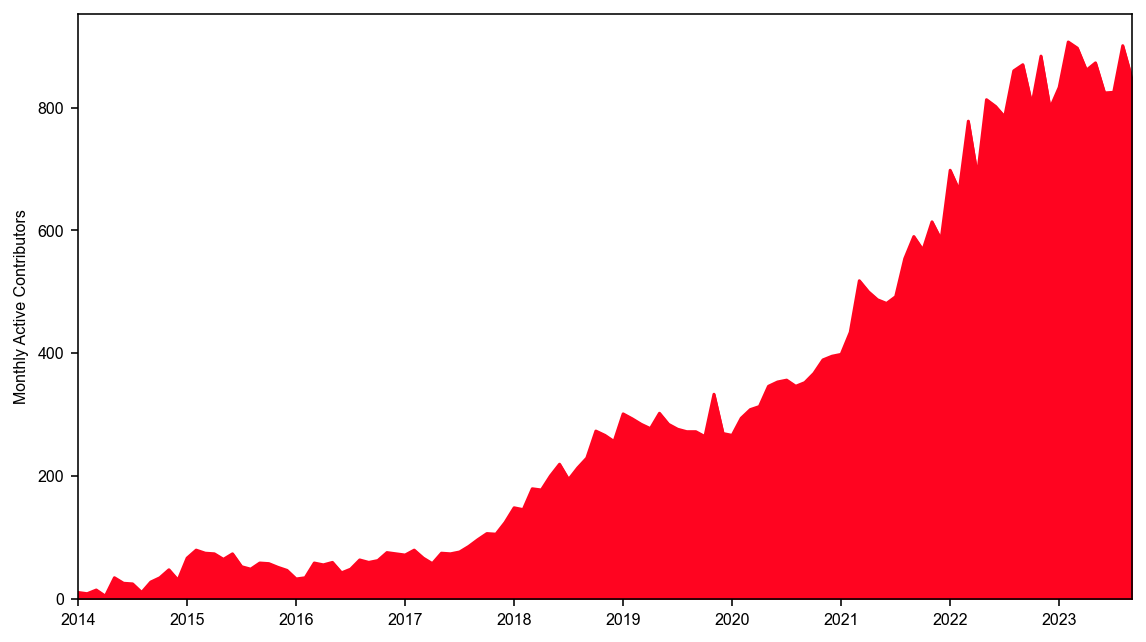

In [14]:
fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
df_contribs[(df_contribs['month']>='2014-01') & (df_contribs['month']<'2023-11')].groupby('month')['sum'].sum().plot(kind='area', ax=ax, color="#FF0420")
ax.set_xlim([0,116])
ax.set_xticks([0,12,24,36,48,60,72,84,96,108])
ax.set_xticklabels(['2014', '2015', '2016', '2017','2018', '2019','2020', '2021', '2022', '2023'])
ax.set_xlabel("")
ax.set_ylabel("Monthly Active Contributors")
fig.tight_layout()

In [15]:
contribution_heatmap(
    df_contribs[(df_contribs['month']>='2014-01') & (df_contribs['month']<'2023-10')], 
    index_col='slug', 
    column_col='month', 
    value_col='sum', 
    sort_label_method='mean',
    cmap='Reds',
    vmax=10,
    #figsize=(32,18)
)

(<Figure size 7020x17820 with 1 Axes>, <AxesSubplot:>)